In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle

%matplotlib inline

font = 'Arial'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font
plt.rcParams['mathtext.bf'] = font
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

linewidth = 2.5

In [2]:
def extract_score(file_name, seed_list, test_flag, ver2_flag=1):
    total_score, total_len = None, 0
    total_sample = None
    for seed in seed_list:
        if test_flag == 0:
            df = pd.read_csv(file_name + str(seed) + '/train.csv')
        else:
            df = pd.read_csv(file_name + str(seed) + '/eval.csv')
        if total_score is None:
            if ver2_flag == 1:
                total_score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                total_score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                total_score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            else:
                total_score = df['episode_reward'].values
            total_len = len(total_score)
            total_score = total_score.reshape(1, -1)
            total_sample = df['step'].values
            total_sample = total_sample.reshape(1, -1)
        else:
            if ver2_flag == 1:
                score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            else:
                score = df['episode_reward'].values
            temp_len = len(score)
            score = score.reshape(1, -1)
            sample = df['step'].values
            sample = sample.reshape(1, -1)
            
            if temp_len < total_len:
                total_len = temp_len
                total_sample = sample
                
            total_score = np.concatenate(
                (total_score[:, :total_len], 
                 score[0][:total_len].reshape(1, -1)), 
                axis=0)
            
    total_avg = np.average(total_score, axis=0)
    total_std = np.std(total_score, axis=0)
    return total_avg, total_std, total_sample, total_score

In [3]:
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [4]:
def draw_figures(x_val, avg_val, std_val, ax, color, label, dash=False):
    if dash:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25, linestyle=':')
        
    else:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25)
    
    ax.fill_between(x_val, 
                    avg_val - std_val, 
                    avg_val + std_val, 
                    facecolor=color[:4], 
                    edgecolor=(0, 0, 0, 0))
    return ax

In [5]:
red_color = (247/255, 112/255, 136/255, 0.15)
blue_color = (128/255, 150/255, 244/255, 0.15)
dark_blue_color = (0/255, 83/255, 214/255, 0.15)
green_color = (51/255, 176/255, 122/255, 0.15)
purple_color = (204/255, 122/255, 244/255, 0.15)
orange_color = (255/255, 161/255, 0/255, 0.15)
black_color = (0/255, 0/255, 0/255, 0.15)
berkeley_blue_color = (0/255,50/255,98/255, 0.15)
cali_gold_color = (253/255,181/255,21/255, 0.15)
real_blue_color = (0/255, 0/255, 244/255, 0.15)
real_green_color = (0/255, 255/255, 0/255, 0.15)
real_red_color = (255/255, 0/255, 0/255, 0.15)
new_green_color = (92/255, 148/255, 13/255, 0.15) 
new_purple_color = (134/255, 46/255, 156/255, 0.15) 
new_yellow_color = (255/255, 224/255, 102/255, 0.15) 
deeppink_color = (255/255, 20/255, 147/255, 0.15)

color_list =[red_color, blue_color, dark_blue_color,
             green_color, purple_color, orange_color, 
             black_color,  
             real_red_color, real_green_color, real_blue_color, 
             new_green_color, new_purple_color, new_yellow_color]
color_max = len(color_list)

# Setup

In [6]:
domain_name = 'quadruped' # 'cartpole' 'cheetah'
task_name = 'walk' # 'swingup' 'run'
env_name = domain_name + '_' + task_name
score_thres = 0.8
arch = 'H1024_L2'

# Normal - PPO

In [7]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PPO/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.00005

ppo_normal_avg, ppo_normal_std, ppo_normal_step = dict(), dict(), dict()
ppo_normal_name_list = []

key = 'ppo: normal'
ppo_normal_name_list.append(key)
file_name = root_dir + 'normalized_' + env_name

file_name += '/lr_' + str(lr) + '_batch_128_nenvs_16_nsteps_500_ent_0.0_hidden_256'
file_name += '_sde_1_sdefreq_4_gae_0.9_clip_0.4_nepochs_20_seed_'
total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1)
ppo_normal_avg[key] = total_avg
ppo_normal_std[key] = total_std
ppo_normal_step[key] = total_sample

In [8]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PPO_Unsuper/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.00005

ppo_un_normal_avg, ppo_un_normal_std, ppo_un_normal_step = dict(), dict(), dict()
ppo_un_normal_name_list = []

key = 'ppo: normal'
ppo_un_normal_name_list.append(key)
file_name = root_dir + 'normalized_' + env_name

file_name += '/lr_' + str(lr) + '_batch_128_nenvs_16_nsteps_500_ent_0.0_hidden_256'
file_name += '_sde_1_sdefreq_4_gae_0.9_clip_0.4_nepochs_20_unsuper_32000_update_50_seed_'
total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1)
ppo_un_normal_avg[key] = total_avg
ppo_un_normal_std[key] = total_std
ppo_un_normal_step[key] = total_sample

# Preference PPO

In [9]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PrefPPO/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

un_pre_ppo_avg, un_pre_ppo_std, un_pre_ppo_step = dict(), dict(), dict()
s_un_pre_ppo_avg, s_un_pre_ppo_std, s_un_pre_ppo_step = dict(), dict(), dict()
un_pre_ppo_name_list = []

un_pre_ppo_tot, s_un_pre_ppo_tot = dict(), dict()

lr= 0.00005
feed_type = 1

fedd_teacher_option_list = [
#     (32000, 50, 2000, 200, 16, 'o'),
    (320000, 50, 2000, 200, 16, 'o'),
    (32000, 50, 1000, 100, 16, 'o'),
#     (320000, 50, 1000, 100, 16, 'o'),
    
    (32000, 50, 2000, 200, 16, 'n'),
#     (320000, 50, 2000, 200, 16, 'n'),
    (32000, 50, 1000, 100, 16, 'n'),
#     (320000, 50, 1000, 100, 16, 'n'),
    
#     (32000, 50, 2000, 200, 16, 's'),
    (320000, 50, 2000, 200, 16, 's'),
    (32000, 50, 1000, 100, 16, 's'),
#     (320000, 50, 1000, 100, 16, 's'),
    
    (32000, 50, 2000, 200, 16, 'e'),
#     (320000, 50, 2000, 200, 16, 'e'),
    (32000, 50, 1000, 100, 16, 'e'),
#     (320000, 50, 1000, 100, 16, 'e'),
    
    (32000, 50, 2000, 200, 16, 'my'),
#     (320000, 50, 2000, 200, 16, 'my'),
    (32000, 50, 1000, 100, 16, 'my'),
#     (320000, 50, 1000, 100, 16, 'my'),
    
#     (32000, 50, 2000, 200, 16, 'mi'),
    (320000, 50, 2000, 200, 16, 'mi'),
#     (32000, 50, 1000, 100, 16, 'mi'),
    (320000, 50, 1000, 100, 16, 'mi'),
]

for interact, seg_size, max_feed, rbatch, nenvs, teacher_index in fedd_teacher_option_list:
    if teacher_index == 'n':
        teacher_dir = '/teacher_1.0_1.0_0.0_0.0_0.0'
    elif teacher_index == 'my':
        teacher_dir = '/teacher_-1.0_0.9_0.0_0.0_0.0'
    elif teacher_index == 'mi':
        teacher_dir = '/teacher_-1.0_1.0_0.1_0.0_0.0'
    elif teacher_index == 's':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.1_0.0'
    elif teacher_index == 'o':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.0_0.0'
    elif teacher_index == 'e':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.0_0.1'

    key = 'PrePPO [' + str(feed_type) + '] (max='+ str(max_feed) + ', seg=' + str(seg_size)
    key += ', int=' + str(interact) + ', rb=' + str(rbatch) + ', nenv=' + str(nenvs)
    key += ', te=' + str(teacher_index) + ')'
    un_pre_ppo_name_list.append(key)
    
    file_name = root_dir + 'normalized_' + env_name
    file_name += teacher_dir
    file_name += '/lr_' + str(lr) + '_reward_lr0.0003_seg' + str(seg_size) + '_acttanh'
    file_name += '_inter' + str(interact) + '_type' + str(feed_type)
    file_name += '_large10_rebatch' + str(rbatch)
    file_name += '_reupdate100_batch_128'
    file_name += '_nenvs_' + str(nenvs)
    file_name += '_nsteps_500_ent_0.0_hidden_256_sde_1_sdefreq_4'
    file_name += '_gae_0.9_clip_0.4_nepochs_20_maxfeed_'+str(max_feed)
    file_name += '_unsuper_32000_update_50'
    file_name += '_seed_'
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
    un_pre_ppo_avg[key] = total_avg
    un_pre_ppo_std[key] = total_std
    un_pre_ppo_step[key] = total_sample
    un_pre_ppo_tot[key] = total_score
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=5)
    s_un_pre_ppo_avg[key] = total_avg
    s_un_pre_ppo_std[key] = total_std
    s_un_pre_ppo_step[key] = total_sample

# PPO PLOT

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


mean: 490.44472680125
std: 114.75994359617539
mean: 491.41962379375
std: 139.25983990619451
mean: 363.4964363175
std: 45.478679050346706
mean: 343.50043818
std: 79.84623171639983


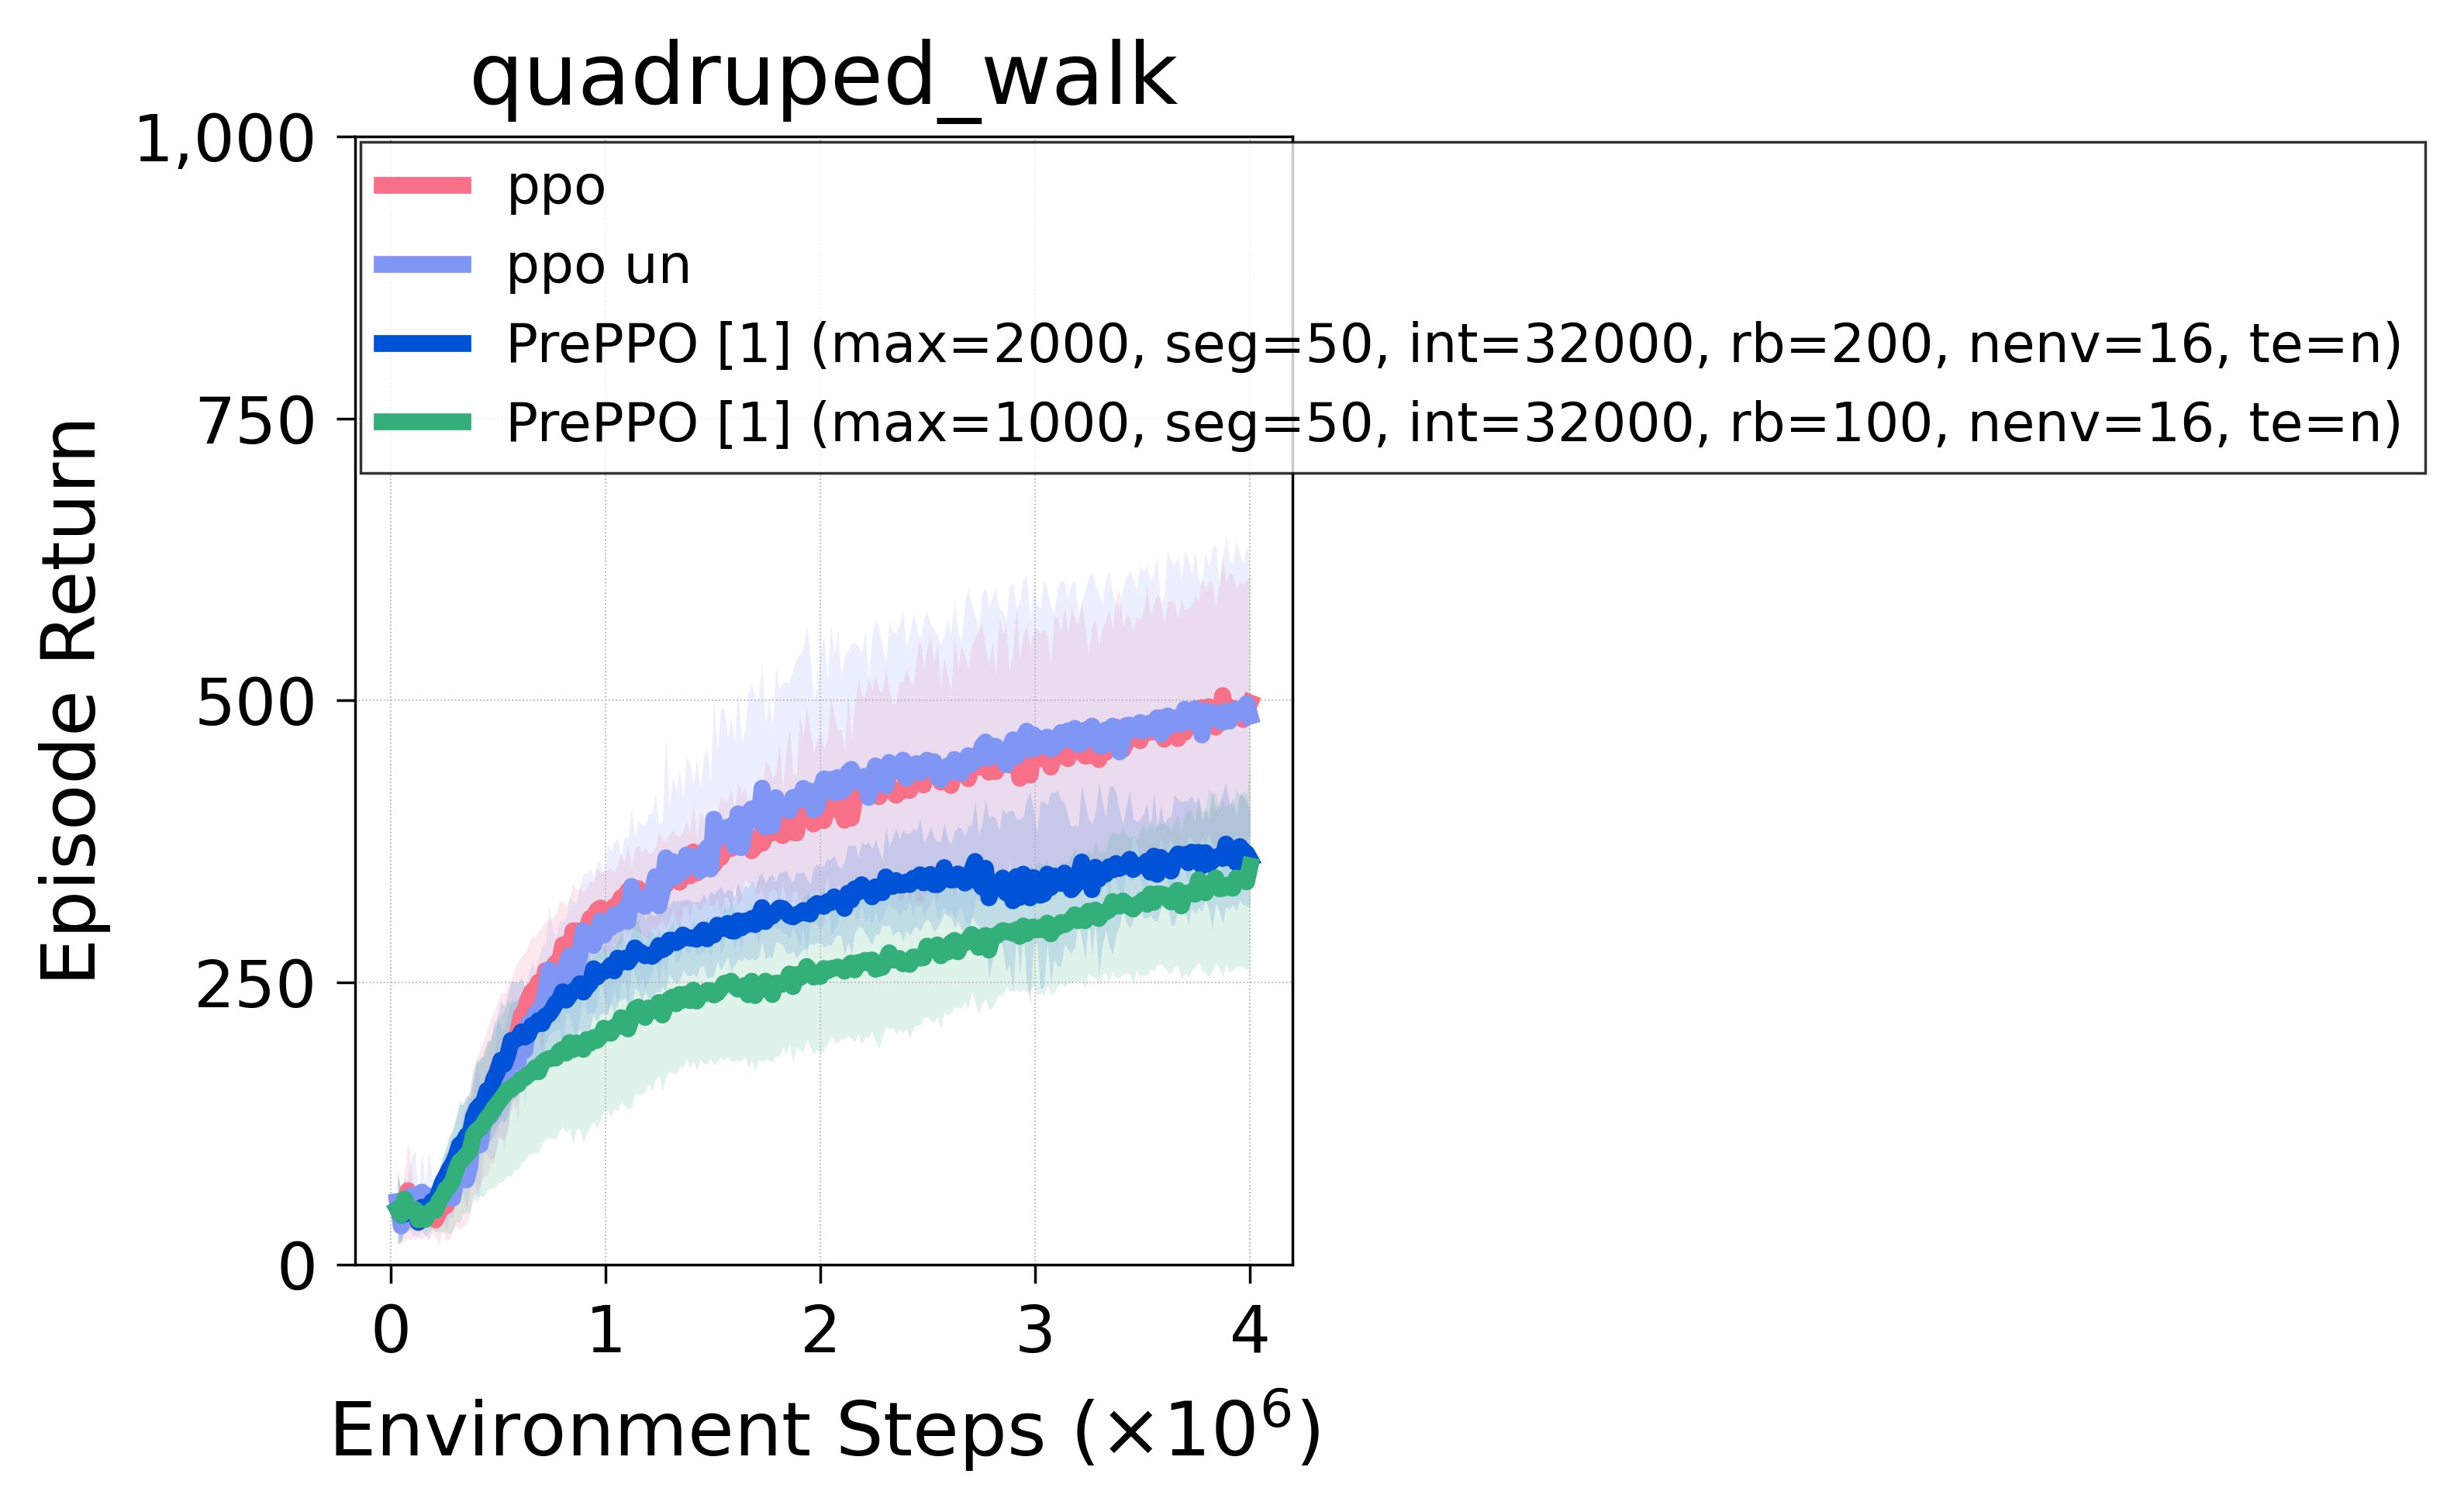

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
base = 1000000

ppo_converge = -5
count = 0
teacher_flag = 'te=n' 
for name in ppo_normal_name_list:            
    label = name
    score = ppo_normal_avg[name]
    std = ppo_normal_std[name]
    steps = ppo_normal_step[name].reshape(-1)
    ax = draw_figures(steps/base, score, std, ax, 
                      color_list[count], 'ppo')
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    count += 1
    
for name in ppo_un_normal_name_list:            
    label = name
    score = ppo_un_normal_avg[name]
    std = ppo_un_normal_std[name]
    steps = ppo_un_normal_step[name].reshape(-1)
    ax = draw_figures(steps/base, score, std, ax, 
                      color_list[count], 'ppo un')
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    count += 1
        
for name in un_pre_ppo_name_list:            
    label = name
    score = un_pre_ppo_avg[name]
    std = un_pre_ppo_std[name]
    steps = un_pre_ppo_step[name].reshape(-1)
    if teacher_flag in label:
        ax = draw_figures(steps/base, score, std, ax, 
                          color_list[count], label)
        print('mean: ' + str(np.mean(score[ppo_converge:])))
        print('std: ' + str(np.mean(std[ppo_converge:])))
        count += 1
        
        
ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax.set_ylabel('Episode Return', fontsize=14)
ax.set_title(env_name, fontsize=16)

ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_yticks([0, 250, 500, 750, 1000])
# ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

ax.set_xticks([0, 1, 2, 3, 4])

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax.xaxis.major.formatter._useMathText = True

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1000)

leg = ax.legend(fancybox=False, fontsize=10, 
                edgecolor='black', borderaxespad=0.1, 
                handlelength=1.5, loc='upper left')
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()

# Normal - SAC

In [11]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr_list = [0.0001]
sac_normal_avg, sac_normal_std, sac_normal_step = dict(), dict(), dict()
sac_normal_name_list = []
temp = 0.1

for lr in lr_list:
    key = 'sac: normal ' + str(lr)
    sac_normal_name_list.append(key)
    file_name = root_dir + env_name + '/' + arch + '_B1024_tau0.005'
    file_name += '/sac_sac_lr' + str(lr) +'_temp' + str(temp) + '_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_normal_avg[key] = total_avg
    sac_normal_std[key] = total_std
    sac_normal_step[key] = total_sample

In [12]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC_UNSUPER/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr_list = [0.0001]
sac_un_normal_avg, sac_un_normal_std, sac_un_normal_step = dict(), dict(), dict()
sac_un_normal_name_list = []
temp = 0.1

for lr in lr_list:
    key = 'sac: normal ' + str(lr)
    sac_un_normal_name_list.append(key)
    file_name = root_dir + env_name + '/' + arch + '_B1024_tau0.005'
    file_name += '/sac_unsup9000_topk5_sac_lr' + str(lr) +'_temp' + str(temp) + '_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_un_normal_avg[key] = total_avg
    sac_un_normal_std[key] = total_std
    sac_un_normal_step[key] = total_sample

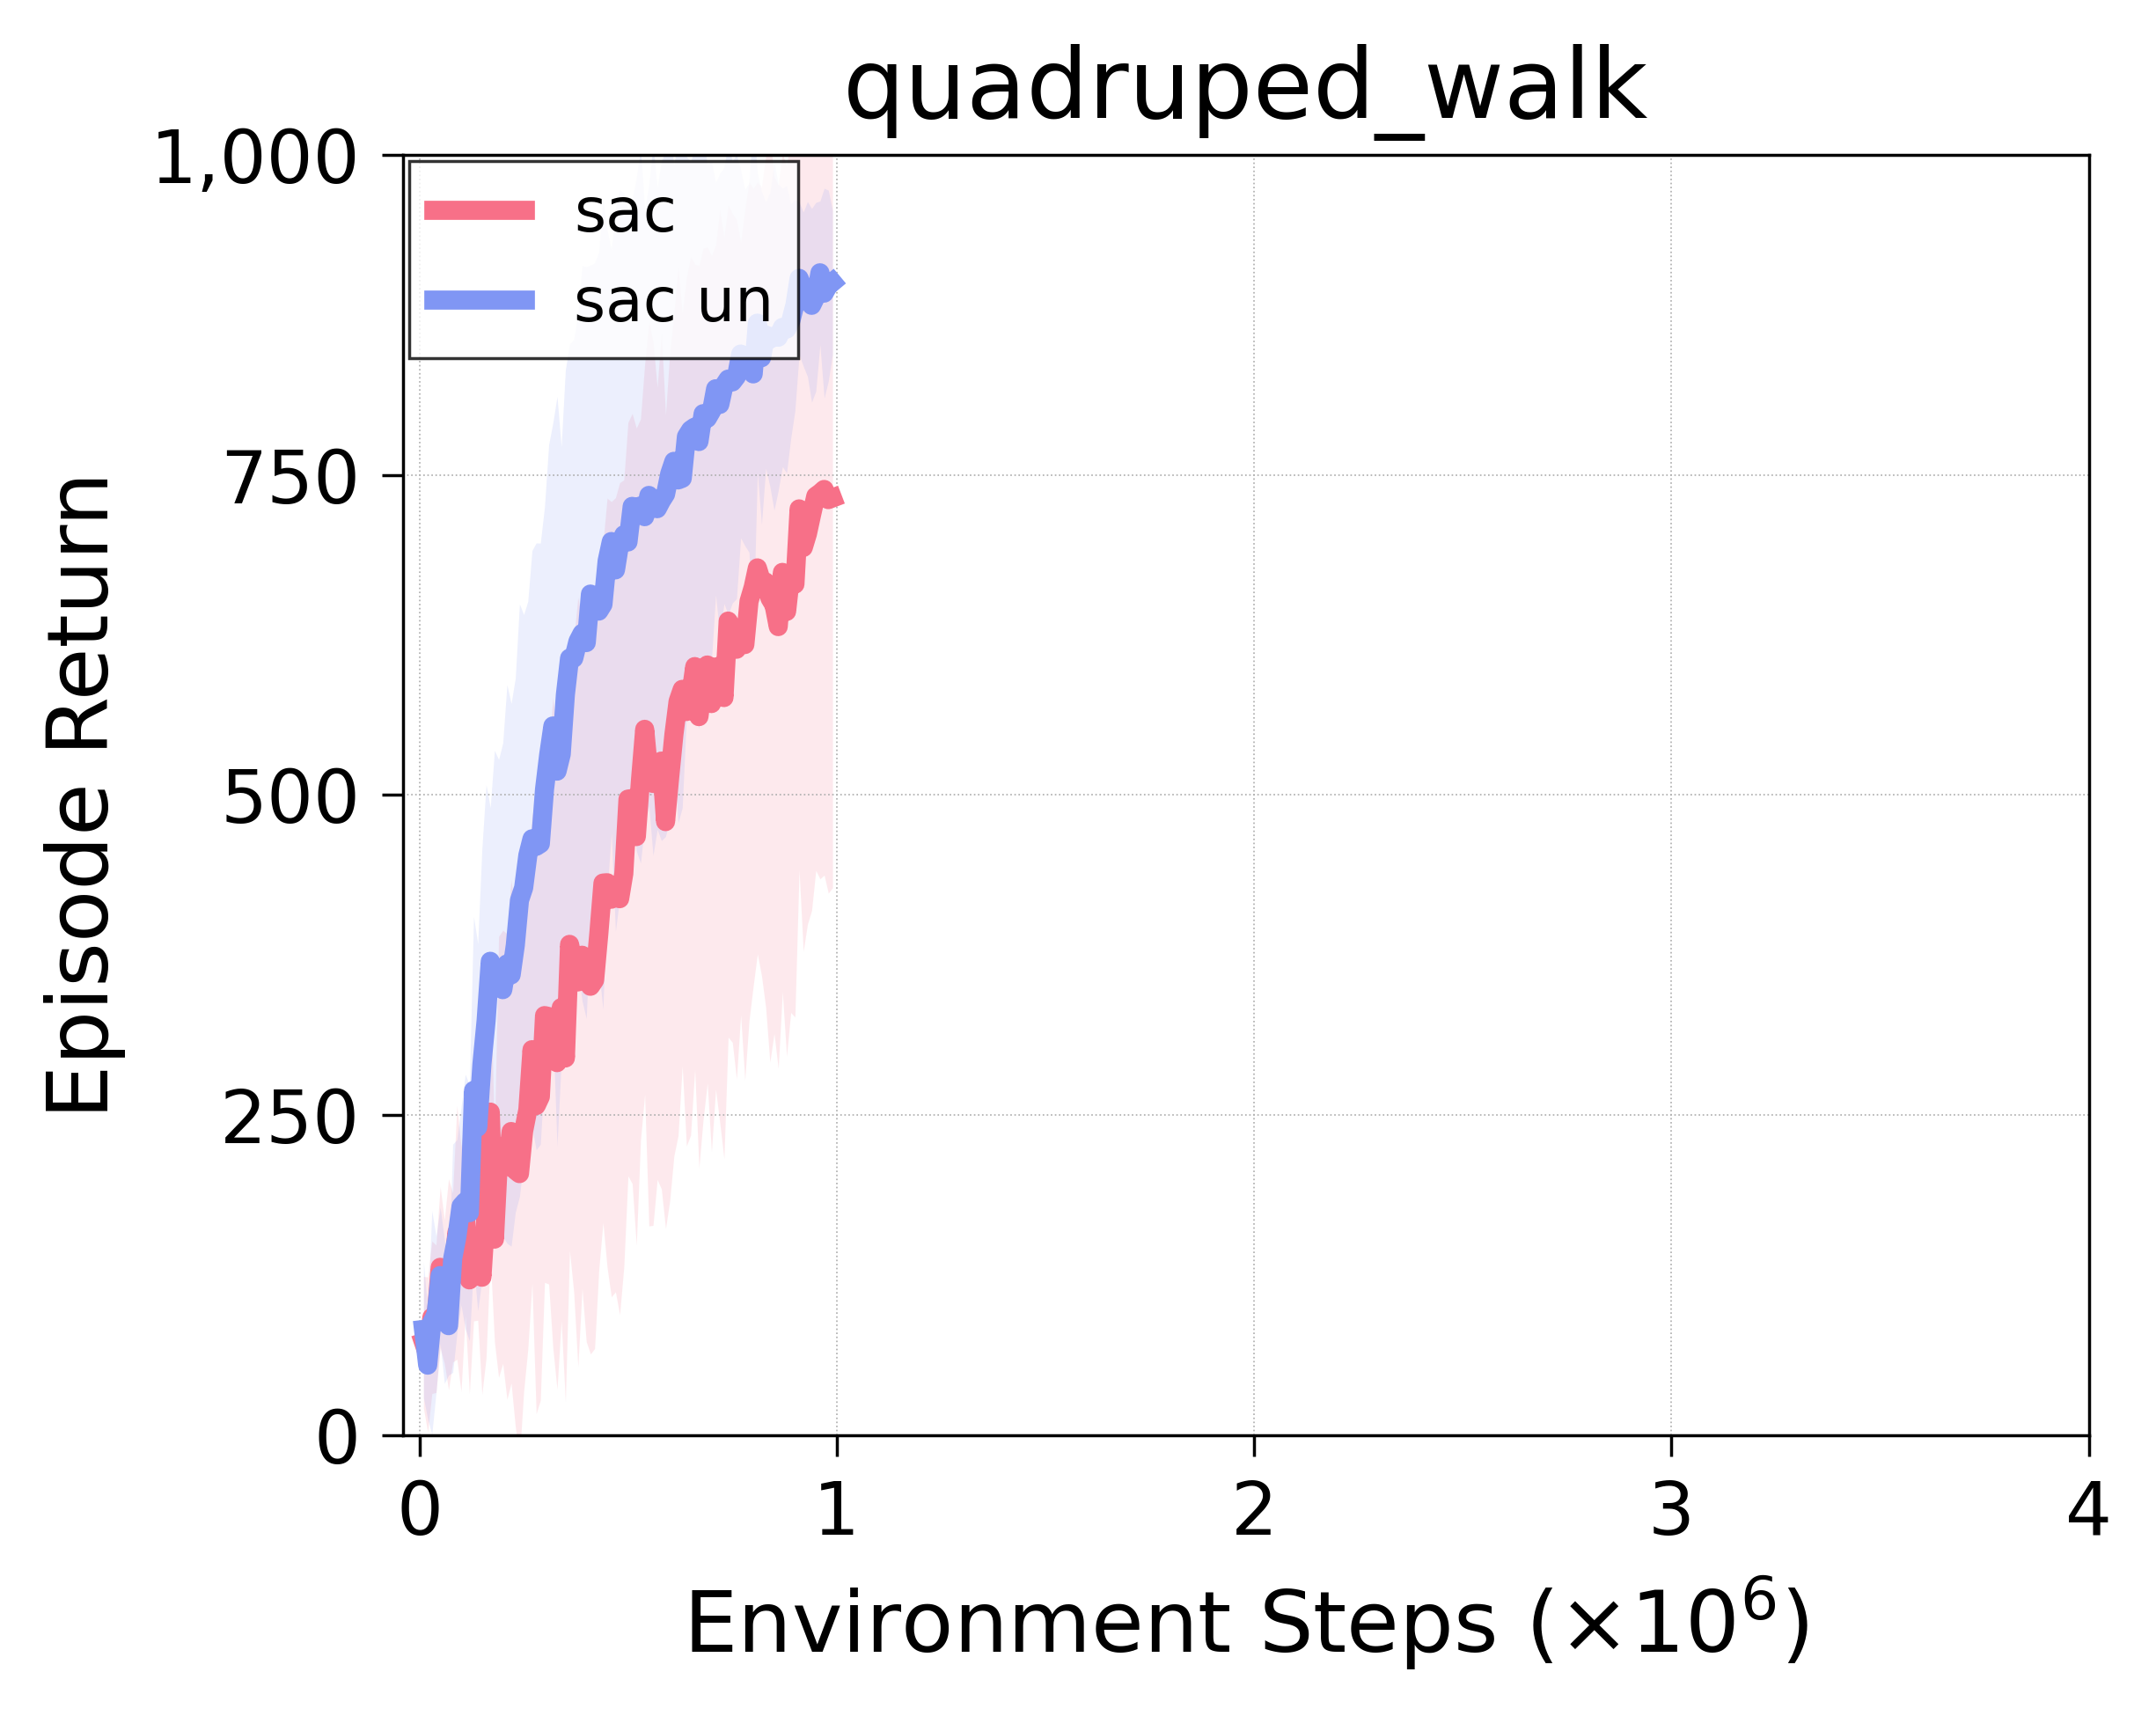

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
base = 1000000

ppo_converge = -5
count = 0
teacher_flag = 'te=n' 
for name in sac_normal_name_list:            
    label = name
    score = sac_normal_avg[name]
    std = sac_normal_std[name]
    steps = sac_normal_step[name].reshape(-1)
    ax = draw_figures(steps/base, score, std, ax, 
                      color_list[count], 'sac')
    count += 1
    
for name in sac_un_normal_name_list:            
    label = name
    score = sac_un_normal_avg[name]
    std = sac_un_normal_std[name]
    steps = sac_un_normal_step[name].reshape(-1)
    ax = draw_figures(steps/base, score, std, ax, 
                      color_list[count], 'sac un')
    count += 1
        
ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax.set_ylabel('Episode Return', fontsize=14)
ax.set_title(env_name, fontsize=16)

ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_yticks([0, 250, 500, 750, 1000])
# ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

ax.set_xticks([0, 1, 2, 3, 4])

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax.xaxis.major.formatter._useMathText = True

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1000)

leg = ax.legend(fancybox=False, fontsize=10, 
                edgecolor='black', borderaxespad=0.1, 
                handlelength=1.5, loc='upper left')
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()

# PEBBLE

In [14]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PEBBLE/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.0001

ori_interact = 30000
ori_num_feed = 200
ori_num_feed_2 = 100

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False



fedd_teacher_option_list = [
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
]

new_pebble_avg, new_pebble_std, new_pebble_step = dict(), dict(), dict()
new_noise_avg, new_noise_std, new_noise_step = dict(), dict(), dict()

new_pebble_total = dict()

new_pebble_name_list = []
teacher_dir = ''
for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    if teacher_index == 'n':
        teacher_dir = '/teacher_b1_g1_m0_s0_e0'
    elif teacher_index == 'my':
        teacher_dir = '/teacher_b-1_g0.9_m0_s0_e0'
    elif teacher_index == 'mi':
        teacher_dir = '/teacher_b-1_g1_m0.1_s0_e0'
    elif teacher_index == 's':
        teacher_dir = '/teacher_b-1_g1_m0_s0.1_e0'
    elif teacher_index == 'o':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    elif teacher_index == 'e':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0.1'

    key = 'PEBBLE [' + str(feed_type) + '] (num_feed='+ str(num_feed) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact)
    key += ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,seg=' + str(segment) + ')'
    new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate50_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
    
    total_avg, total_std, total_sample, total_score  = extract_score(file_name, seed_list, test_flag=1)
    new_pebble_avg[key] = total_avg
    new_pebble_std[key] = total_std
    new_pebble_step[key] = total_sample
    new_pebble_total[key] = total_score

# Main PLOT

PEBBLE (2K):
Oracle: 0.8374834269382652
Mistake: 0.472314850497374
Equal: 1.0330266530832979
Skip: 1.0359773151444727
Myopic: 0.7936862050199678
Stoc: 0.3004291304626991
avg: 0.745486263524346

PEBBLE (1K): 
Oracle: 0.6994464267617965
Mistake: 0.43331253678575876
Equal: 0.8497282169698656
Skip: 0.8799135463910984
Myopic: 0.6539214031083778
Stoc: 0.544522859995082
avg: 0.6768074983353299

PrePPO + Pre (2K): 
Oracle: 0.8789540012096098
Mistake: 0.7092294866059715
Equal: 0.9124438274998313
Skip: 0.8203968245881799
Myopic: 0.6430808796727048
Stoc: 0.7390913480187835
avg: 0.7838660612658468

PrePPO + Pre (1K): 
Oracle: 0.7575791735849076
Mistake: 0.6634158346156293
Equal: 0.8546697763323174
Skip: 0.633133248978647
Myopic: 0.6960579968350824
Stoc: 0.7008325706631696
avg: 0.7176147668349588


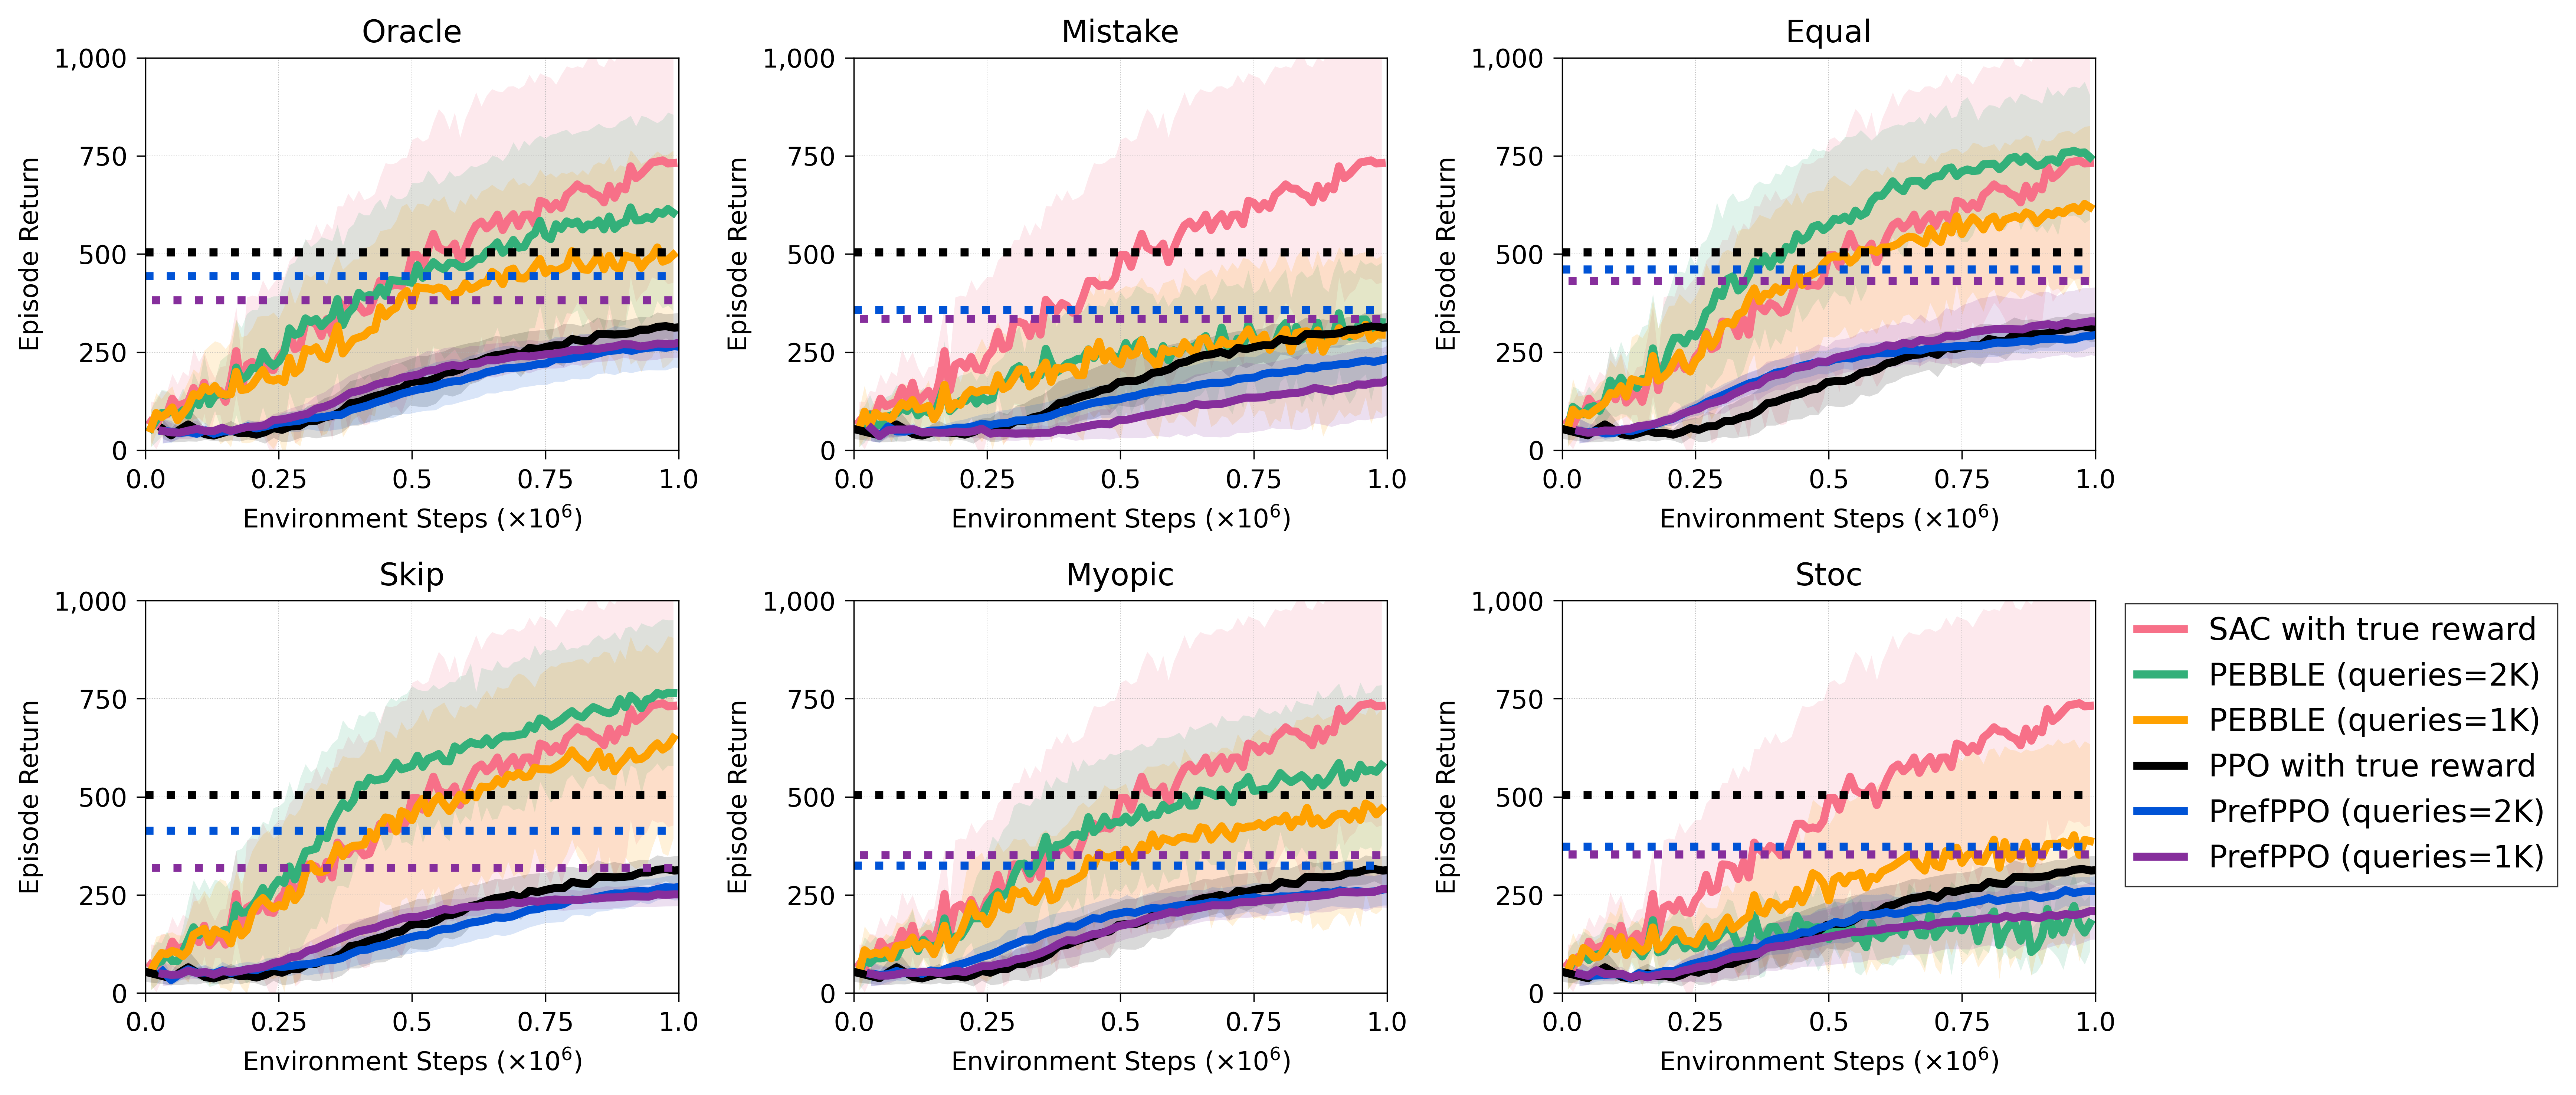

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000

teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10
for index_, ax in enumerate(axes):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
    for name in sac_normal_name_list:
        label = name
        score = sac_normal_avg[name]
        std = sac_normal_std[name]
        steps = sac_normal_step[name].reshape(-1)
        ours_color = color_list[0]
        ax = draw_figures(steps/base, score, std, ax, 
                          sac_color, 'SAC with true reward') 
        sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=200' in name:
            ours_color = color_list[3]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=2K)')
            pebble_2K_max = np.max(score[max_window:])
            
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=100' in name:
            ours_color = color_list[5]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=1K)')
            pebble_1K_max = np.max(score[max_window:])
            
    for name in ppo_normal_name_list:            
        label = name
        score = ppo_normal_avg[name]
        std = ppo_normal_std[name]
        steps = ppo_normal_step[name].reshape(-1)
        ax = draw_figures(steps/base, score, std, ax, 
                          color_list[6], 'PPO with true reward')
        
        final_per = np.zeros(steps.shape[0])
        steps[0] = 0
        final_per[:] = np.max(score[max_window:])
        ppo_max = np.max(score[max_window:])
        ax = draw_figures(steps/base, final_per, 0, ax, 
                          color_list[6], '', dash=2)
                
    for name in un_pre_ppo_name_list:
        label = name
        score = un_pre_ppo_avg[name]
        std = un_pre_ppo_std[name]
        steps = un_pre_ppo_step[name].reshape(-1)
        if preppo_feed_type in name and teacher_flag in name:
            if 'max=2000' in name:
                ours_color = color_list[2]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=2K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 0
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_2K_max = np.max(score[max_window:])
            elif 'max=1000' in name:
                ours_color = new_purple_color
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=1K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 12000
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_1K_max = np.max(score[max_window:])
    
    pebble_2K_list.append(pebble_2K_max/sac_max)
    pebble_1K_list.append(pebble_1K_max/sac_max)
    unprefppo_2K_list.append(un_preppo_2K_max/ppo_max)
    unprefppo_1K_list.append(un_preppo_1K_max/ppo_max)
    
    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Episode Return', fontsize=10)
    ax.set_title(teacher_name, fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 250, 500, 750,  1000])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1000)
    
    if index_ == 5:
        leg = ax.legend(fancybox=False, fontsize=12, bbox_to_anchor=(1.05, 1),
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)
plt.tight_layout()

print('PEBBLE (2K):')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_2K_list[index]))
print('avg: ' + str(np.average(pebble_2K_list)))

print('\nPEBBLE (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_1K_list[index]))
print('avg: ' + str(np.average(pebble_1K_list)))

print('\nPrePPO + Pre (2K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_2K_list[index]))
print('avg: ' + str(np.average(unprefppo_2K_list)))
    
print('\nPrePPO + Pre (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_1K_list[index]))
print('avg: ' + str(np.average(unprefppo_1K_list)))


PEBBLE (2K):
Oracle: 0.6814110965677722
Mistake: 0.3842948646509555
Equal: 0.8405131395073142
Skip: 0.8429139199956597
Myopic: 0.6457758683900939
Stoc: 0.24444154552156966
avg: 0.6065584057722275

PEBBLE (1K): 
Oracle: 0.5690984935577703
Mistake: 0.35256097177611645
Equal: 0.6913739633353913
Skip: 0.7159339937307126
Myopic: 0.532057454545978
Stoc: 0.44304628270909024
avg: 0.5506785266091765

PrePPO + Pre (2K): 
Oracle: 0.8917549166027448
Mistake: 0.7195585671265283
Equal: 0.9257324822198048
Skip: 0.832344924631979
Myopic: 0.6524465847270129
Stoc: 0.7498553308902038
avg: 0.7952821343663791

PrePPO + Pre (1K): 
Oracle: 0.7686124095577977
Mistake: 0.6730776940049643
Equal: 0.8671170209899939
Skip: 0.6423540786712165
Myopic: 0.7061952503363337
Stoc: 0.7110393601304982
avg: 0.7280659689484673


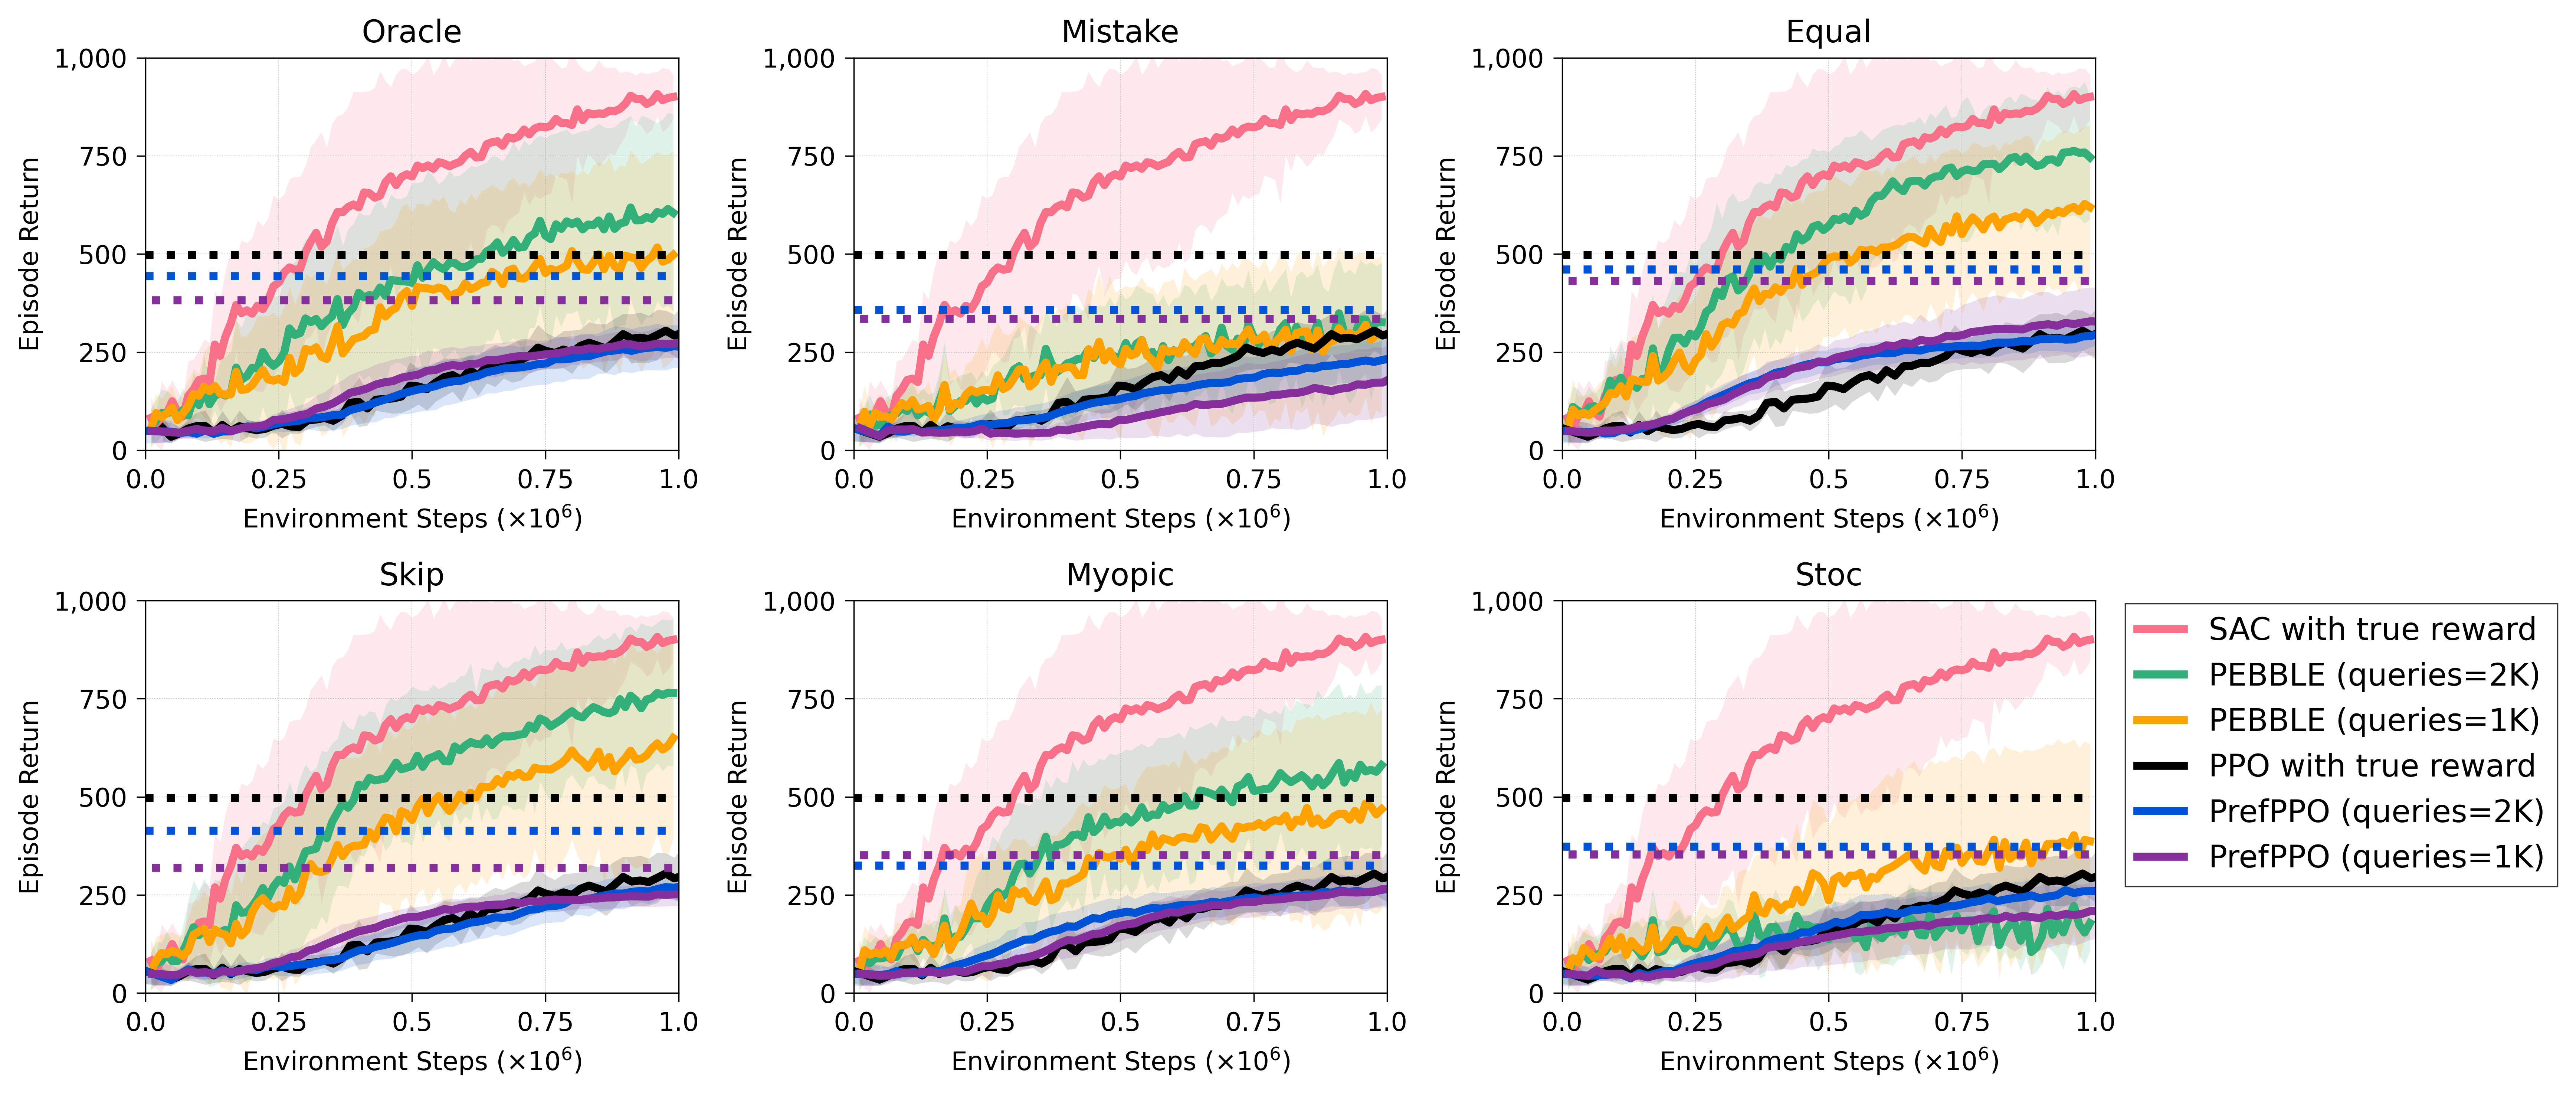

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000

teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10
for index_, ax in enumerate(axes):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
    for name in sac_un_normal_name_list:
        label = name
        score = sac_un_normal_avg[name]
        std = sac_un_normal_std[name]
        steps = sac_un_normal_step[name].reshape(-1)
        ours_color = color_list[0]
        ax = draw_figures(steps/base, score, std, ax, 
                          sac_color, 'SAC with true reward') 
        sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=200' in name:
            ours_color = color_list[3]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=2K)')
            pebble_2K_max = np.max(score[max_window:])
            
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=100' in name:
            ours_color = color_list[5]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=1K)')
            pebble_1K_max = np.max(score[max_window:])
            
    for name in ppo_un_normal_name_list:            
        label = name
        score = ppo_un_normal_avg[name]
        std = ppo_un_normal_std[name]
        steps = ppo_un_normal_step[name].reshape(-1)
        ax = draw_figures(steps/base, score, std, ax, 
                          color_list[6], 'PPO with true reward')
        
        final_per = np.zeros(steps.shape[0])
        steps[0] = 0
        final_per[:] = np.max(score[max_window:])
        ppo_max = np.max(score[max_window:])
        ax = draw_figures(steps/base, final_per, 0, ax, 
                          color_list[6], '', dash=2)
                
    for name in un_pre_ppo_name_list:
        label = name
        score = un_pre_ppo_avg[name]
        std = un_pre_ppo_std[name]
        steps = un_pre_ppo_step[name].reshape(-1)
        if preppo_feed_type in name and teacher_flag in name:
            if 'max=2000' in name:
                ours_color = color_list[2]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=2K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 0
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_2K_max = np.max(score[max_window:])
            elif 'max=1000' in name:
                ours_color = new_purple_color
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=1K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 12000
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_1K_max = np.max(score[max_window:])
    
    pebble_2K_list.append(pebble_2K_max/sac_max)
    pebble_1K_list.append(pebble_1K_max/sac_max)
    unprefppo_2K_list.append(un_preppo_2K_max/ppo_max)
    unprefppo_1K_list.append(un_preppo_1K_max/ppo_max)
    
    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Episode Return', fontsize=10)
    ax.set_title(teacher_name, fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 250, 500, 750,  1000])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1000)
    
    if index_ == 5:
        leg = ax.legend(fancybox=False, fontsize=12, bbox_to_anchor=(1.05, 1),
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)
plt.tight_layout()

print('PEBBLE (2K):')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_2K_list[index]))
print('avg: ' + str(np.average(pebble_2K_list)))

print('\nPEBBLE (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_1K_list[index]))
print('avg: ' + str(np.average(pebble_1K_list)))

print('\nPrePPO + Pre (2K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_2K_list[index]))
print('avg: ' + str(np.average(unprefppo_2K_list)))
    
print('\nPrePPO + Pre (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_1K_list[index]))
print('avg: ' + str(np.average(unprefppo_1K_list)))
plt.savefig('./figure/table1_'+env_name+'.pdf')

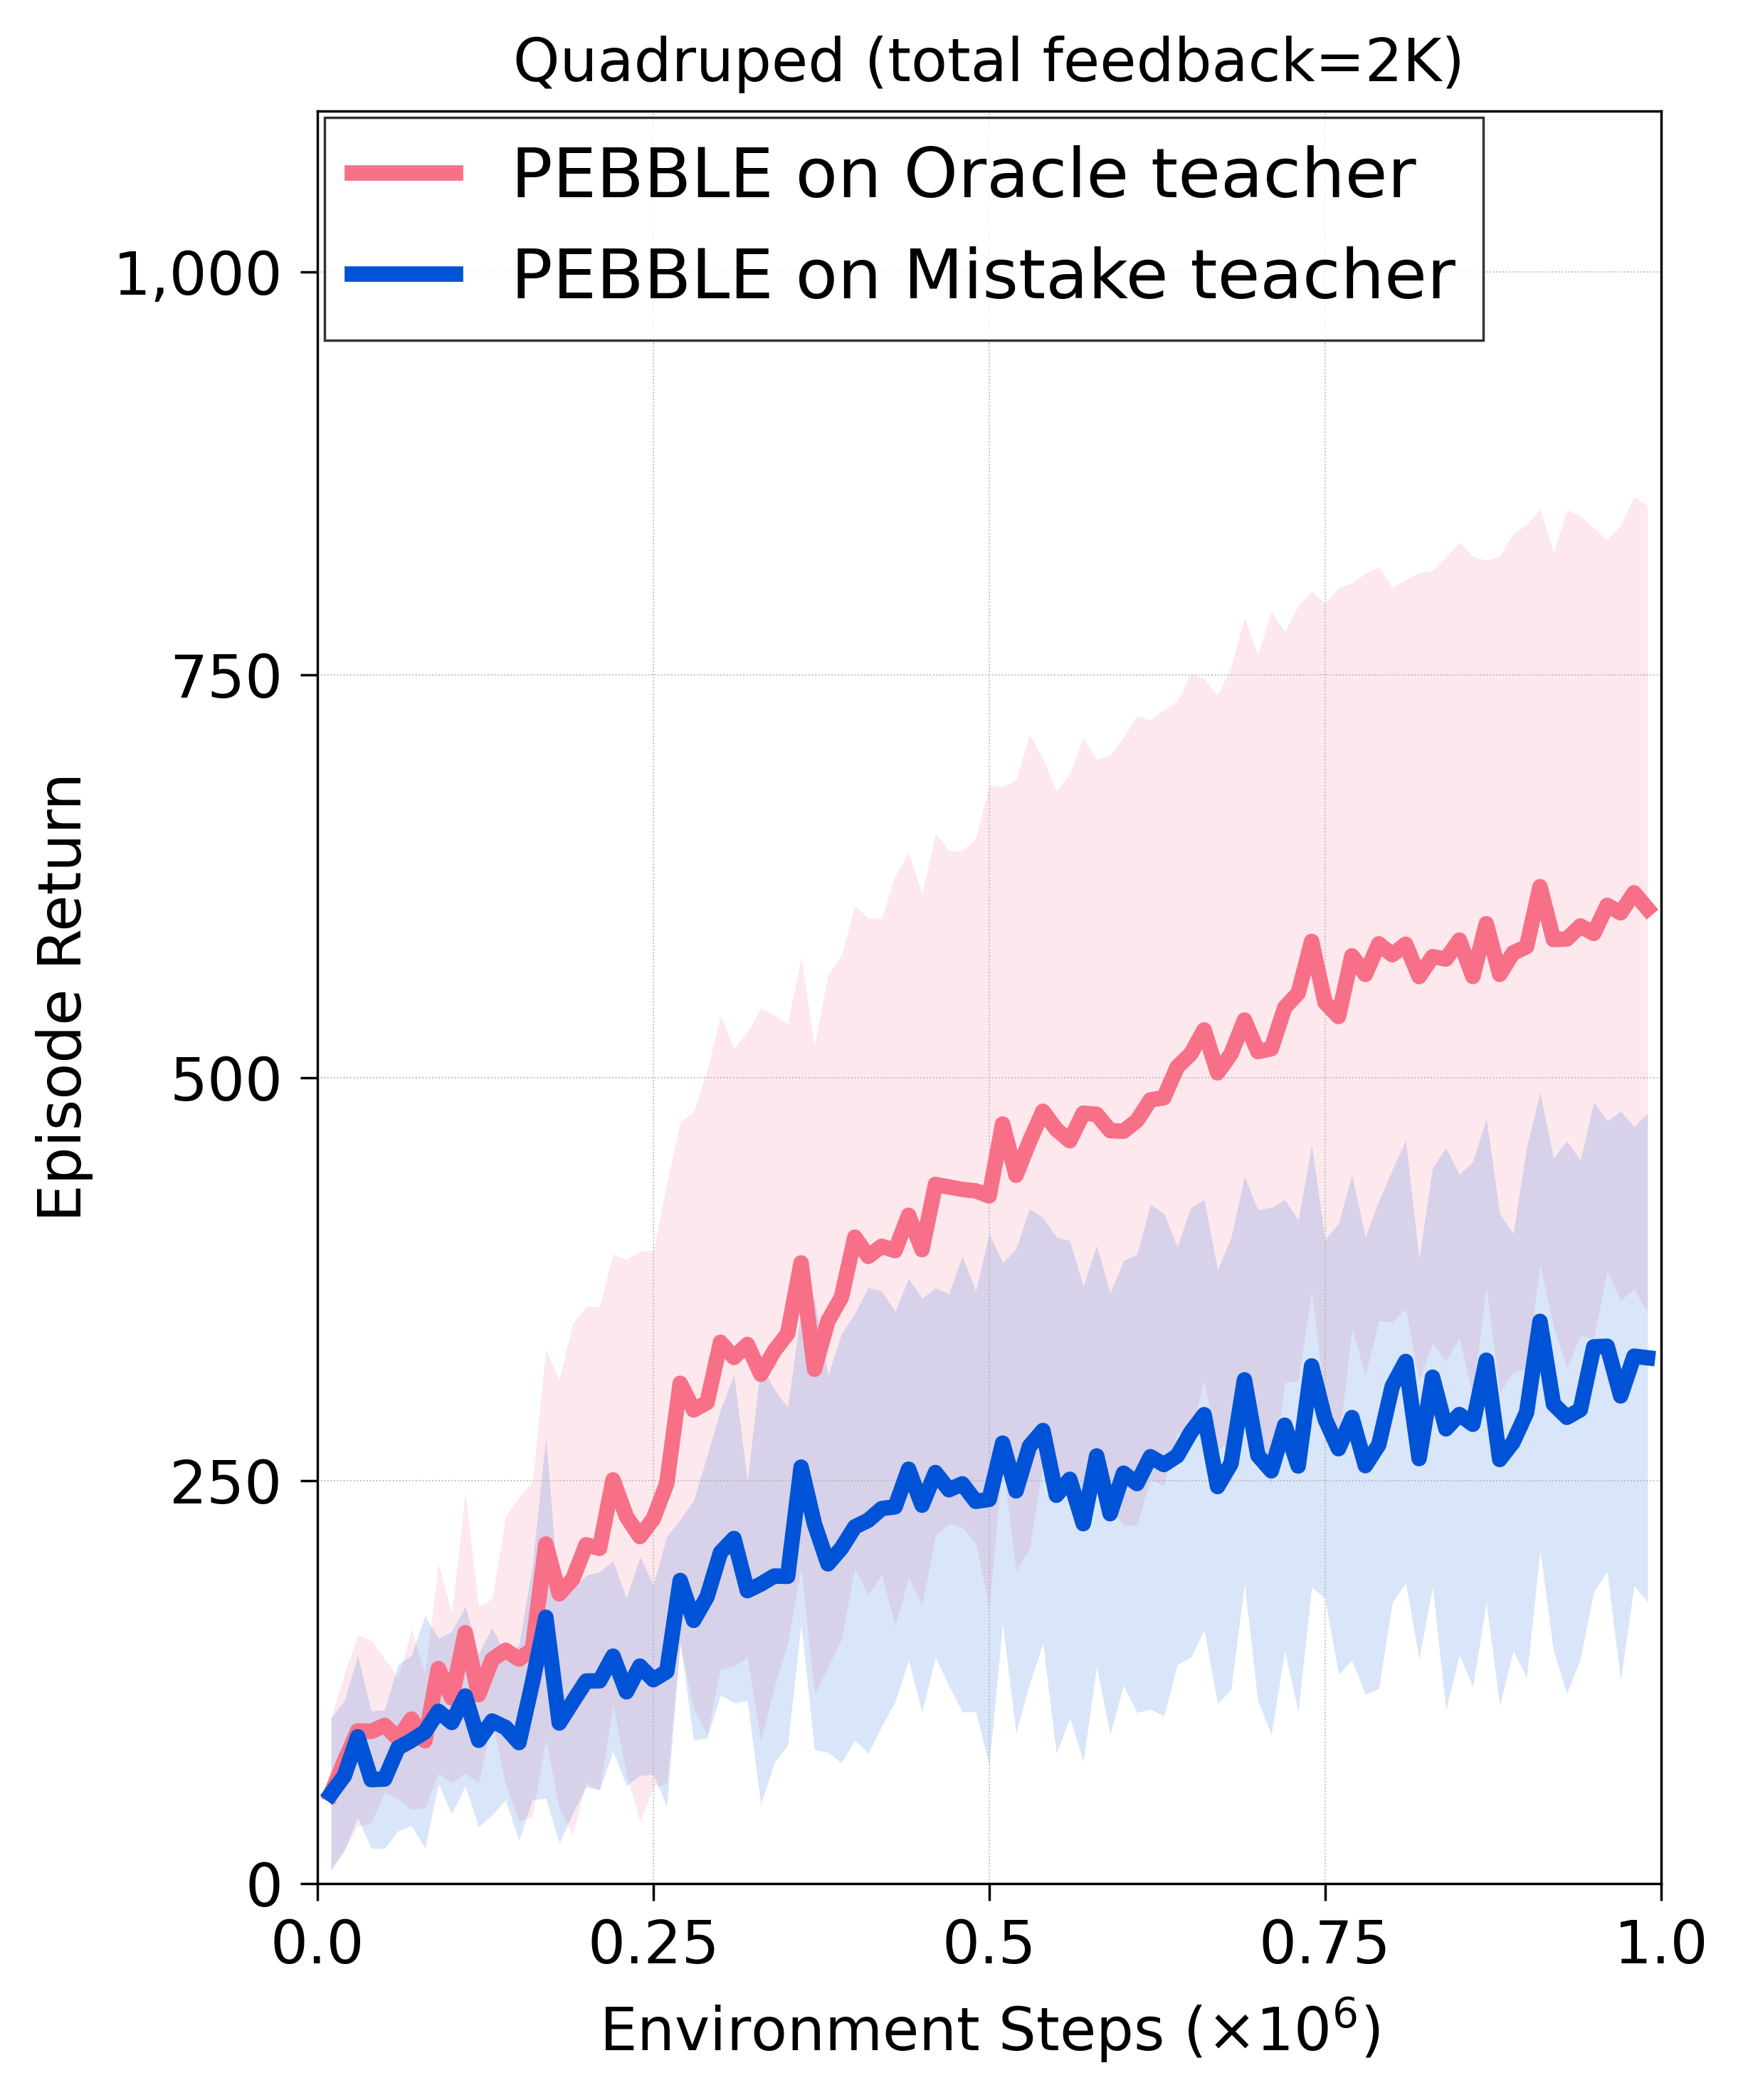

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(5, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000




teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equally preferable', 
                     'Skip', 'Myopic', 'Noisy']

teacher_flag_list = ['te=o', 'te=mi']
teacher_name_list = ['Oracle', 'Mistake']

# teacher_flag_list = ['te=o', 'te=e', 'te=s']
# teacher_name_list = ['Oracle', 'Equal', 
#                      'Skip', 'Myopic']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
prefppo_2K_list, prefppo_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10

for index_, ax in enumerate(axes):
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
#     for name in sac_un_normal_name_list:
#         label = name
#         score = sac_un_normal_avg[name]
#         std = sac_un_normal_std[name]
#         steps = sac_un_normal_step[name].reshape(-1)
#         ours_color = color_list[0]
#         ax = draw_figures(steps/base, score, std, ax, 
#                           sac_color, 'SAC with true reward') 
#         sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)
        for t_index in range(len(teacher_flag_list)):
            teacher_flag = teacher_flag_list[t_index]
            teacher_name = teacher_name_list[t_index]
            if pebble_feed_type in name and teacher_flag in name and 'num_feed=200' in name:
                ours_color = color_list[t_index]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PEBBLE on ' + teacher_name + " teacher")
                pebble_2K_max = np.max(score[max_window:])
                
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=12)
    ax.set_ylabel('Episode Return', fontsize=12)
    ax.set_title('Quadruped (total feedback=2K)', fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_yticks([0, 250, 500, 750,  1000])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1100)
    
    leg = ax.legend(fancybox=False, fontsize=14, 
                    edgecolor='black', borderaxespad=0.1, 
                    handlelength=1.5, loc='upper left')
    leg.get_frame().set_linewidth(0.5)
plt.tight_layout()

# Data generation

In [18]:
## Variables
max_window = -10
teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']
## Extract score
for name in sac_normal_name_list:
    label = name
    score = sac_normal_avg[name]
    std = sac_normal_std[name]
    sac_max = np.max(score)

for name in sac_un_normal_name_list:
    label = name
    score = sac_un_normal_avg[name]
    sac_un_max = np.max(score)
    
PEBBLE_score = dict()
for index_ in range(len(teacher_flag_list)):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    for name in new_pebble_name_list:
        label = name
        if teacher_flag in name:
            if 'num_feed=200' in name:
                store_name = "PEBBLE (2K) (" + teacher_name + ")"
            if 'num_feed=100' in name:
                store_name = "PEBBLE (1K) (" + teacher_name + ")"
            total_score = new_pebble_total[name]
            sac_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_max
            sac_un_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_un_max
#             PEBBLE_score[store_name] = sac_norm.reshape(-1,1)
            PEBBLE_score[store_name] = sac_un_norm.reshape(-1,1)

In [19]:
for name in ppo_normal_name_list:            
    label = name
    score = ppo_normal_avg[name]
    ppo_max = np.max(score)
    
for name in ppo_un_normal_name_list:            
    label = name
    score = ppo_un_normal_avg[name]
    ppo_un_max = np.max(score)

PrefPPO_score = dict()
for index_ in range(len(teacher_flag_list)):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    for name in un_pre_ppo_name_list:
        label = name
        if teacher_flag in name:
            if 'max=2000' in name:
                store_name = "PrefPPO (2K) (" + teacher_name + ")"
            elif 'max=1000' in name:
                store_name = "PrefPPO (1K) (" + teacher_name + ")"
            
            total_score = un_pre_ppo_tot[name]
            ppo_norm = np.mean(total_score[:,max_window:-1], axis=1) / ppo_max
            ppo_un_norm = np.mean(total_score[:,max_window:-1], axis=1) / ppo_un_max
#             PrefPPO_score[store_name] = ppo_norm.reshape(-1,1)
            PrefPPO_score[store_name] = ppo_un_norm.reshape(-1,1)

In [20]:
save_dict(PEBBLE_score, './data/quadruped_pebble.pkl')
save_dict(PrefPPO_score, './data/quadruped_prefppo.pkl')